Forces:
tensor([[[-0.6392, -0.7031],
         [ 0.0000,  0.0000],
         [-0.0067, -0.0197]],

        [[-0.6392, -0.7031],
         [ 0.0000,  0.0000],
         [-0.0067, -0.0197]],

        [[ 0.0305,  0.1363],
         [ 0.0000,  0.0000],
         [-0.4995, -1.2486]]])


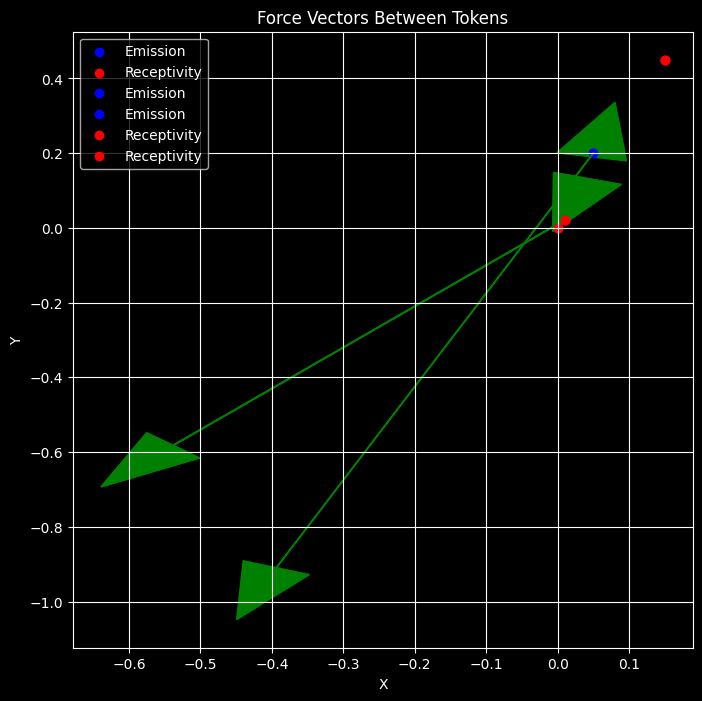

.......
----------------------------------------------------------------------
Ran 7 tests in 0.035s

OK


In [42]:
import unittest
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

def calculate_forces(emissions, receptivity, positions, decay_factor=2, epsilon=1e-8):
    # Calculate the pairwise difference
    force_directions = emissions.unsqueeze(2) - receptivity.unsqueeze(1)  # [batch, seq, seq, dims]
    
    # Compute distances
    distances = torch.norm(force_directions, dim=-1, keepdim=True)  # [batch, seq, seq, 1]
    
    # Normalize forces
    normalized_forces = force_directions / (distances + epsilon)
    
    # Compute force magnitudes
    charges = (emissions.unsqueeze(2) * receptivity.unsqueeze(1)).sum(dim=-1, keepdim=True)  # [batch, seq, seq, 1]
    magnitudes = charges / (distances ** decay_factor + epsilon)  # [batch, seq, seq, 1]
    
    # Combine direction and magnitude
    forces = normalized_forces * magnitudes
    
    return forces


class ForceDirectedAttention(nn.Module):
    def __init__(self, dims, heads):
        super().__init__()
        self.dims = dims
        self.heads = heads
        
        # Each token learns how to emit force vectors
        self.force_emitter = nn.Linear(dims, dims)
        
        # Each token learns its response to incoming forces
        self.force_receptor = nn.Linear(dims, dims)
        
        # Direction-dependent strength modulation
        self.direction_modulator = nn.Parameter(torch.randn(heads, dims))
        
        # Force calculation projections
        self.q_proj = nn.Linear(dims, dims)
        self.k_proj = nn.Linear(dims, dims)
        self.v_proj = nn.Linear(dims, dims)
        self.output = nn.Linear(dims, dims)
    
    def forward(self, x):
        batch, seq_len = x.shape[:2]
        
        # Calculate emission and reception properties
        emissions = self.force_emitter(x)
        receptivity = self.force_receptor(x)
        
        # Standard projections
        q = self.q_proj(x).view(batch, seq_len, self.heads, -1).transpose(1, 2)
        k = self.k_proj(x).view(batch, seq_len, self.heads, -1).transpose(1, 2)
        v = self.v_proj(x).view(batch, seq_len, self.heads, -1).transpose(1, 2)
        
        # Calculate force vectors between all pairs of tokens
        # Instead of simple dot products, we compute vector forces
        token_i = emissions.unsqueeze(2)  # [batch, seq, 1, dim]
        token_j = receptivity.unsqueeze(1)  # [batch, 1, seq, dim]
        
        # Force direction vector (not just magnitude)
        force_directions = token_i - token_j  # [batch, seq, seq, dim]
        force_magnitudes = torch.norm(force_directions, dim=-1, keepdim=True)
        normalized_forces = force_directions / (force_magnitudes + 1e-8)
        
        # Create a tensor to hold the direction scores for each head
        direction_scores = torch.zeros(batch, self.heads, seq_len, seq_len, device=x.device)
        
        # Calculate direction scores for each head separately
        for h in range(self.heads):
            # Get the direction modulator for this head
            # Shape: [1, 1, 1, dims]
            head_modulator = self.direction_modulator[h].unsqueeze(0).unsqueeze(0).unsqueeze(0)
            
            # Calculate dot products between normalized forces and head modulator
            # Shape: [batch, seq_len, seq_len, dims]
            dot_products = normalized_forces * head_modulator
            
            # Sum over the dims dimension to get scores
            # Shape: [batch, seq_len, seq_len]
            head_scores = dot_products.sum(dim=-1)
            
            # Store the scores for this head
            direction_scores[:, h] = head_scores
        
        # Reshape force_magnitudes for broadcasting with direction_scores
        # Shape: [batch, 1, seq_len, seq_len]
        broadcast_magnitudes = force_magnitudes.squeeze(-1).unsqueeze(1)
        
        # Combined force effect (analogous to attention scores)
        # Shape: [batch, heads, seq_len, seq_len]
        force_field = direction_scores * torch.exp(-broadcast_magnitudes)
        
        # Convert force field to attention weights
        weights = F.softmax(force_field, dim=-1)
        
        # Apply weights to values
        output = torch.matmul(weights, v)
        output = output.transpose(1, 2).contiguous().reshape(batch, seq_len, -1)
        
        return self.output(output)


class TestForceDirectedAttention(unittest.TestCase):
    
    def setUp(self):
        torch.manual_seed(42)
        np.random.seed(42)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        self.dims = 64
        self.heads = 8
        self.batch_size = 8
        self.seq_len = 8
        
        self.model = ForceDirectedAttention(
            dims=self.dims,
            heads=self.heads
        ).to(self.device)
        
        self.x = torch.randn(self.batch_size, self.seq_len, self.dims, device=self.device)
        
    def test_initialization(self):
        """Test that the model initializes correctly with different parameters."""
        model = ForceDirectedAttention(dims=64, heads=4)
        self.assertEqual(model.dims, 64)
        self.assertEqual(model.heads, 4)
        
        model = ForceDirectedAttention(dims=128, heads=8)
        self.assertEqual(model.dims, 128)
        self.assertEqual(model.heads, 8)
        
        self.assertIsInstance(model.force_emitter, torch.nn.Linear)
        self.assertIsInstance(model.force_receptor, torch.nn.Linear)
        self.assertIsInstance(model.q_proj, torch.nn.Linear)
        self.assertIsInstance(model.k_proj, torch.nn.Linear)
        self.assertIsInstance(model.v_proj, torch.nn.Linear)
        self.assertIsInstance(model.output, torch.nn.Linear)
        
        self.assertEqual(model.direction_modulator.shape, (8, 128))
        
    def test_forward_output_shape(self):
        """Test that the forward pass produces outputs of the expected shape."""
        output = self.model(self.x)
        self.assertEqual(output.shape, (self.batch_size, self.seq_len, self.dims))
        
        x = torch.randn(5, self.seq_len, self.dims, device=self.device)
        output = self.model(x)
        self.assertEqual(output.shape, (5, self.seq_len, self.dims))
        
        x = torch.randn(self.batch_size, 20, self.dims, device=self.device)
        output = self.model(x)
        self.assertEqual(output.shape, (self.batch_size, 20, self.dims))
        
    def test_force_direction_calculation(self):
        """Test that force direction vectors are calculated correctly."""
        batch_size = 8
        seq_len = 3
        dims = 4
        heads = 2
        
        model = ForceDirectedAttention(dims=dims, heads=heads)
        
        with torch.no_grad():
            model.force_emitter.weight.fill_(0)
            model.force_emitter.bias.fill_(0)
            model.force_receptor.weight.fill_(0)
            model.force_receptor.bias.fill_(0)
            
            for i in range(dims):
                model.force_emitter.weight[i, i] = 1
                model.force_receptor.weight[i, i] = 1
        
        x = torch.zeros(batch_size, seq_len, dims)
        x[0, 0, :] = torch.tensor([1., 0., 0., 0.])
        x[0, 1, :] = torch.tensor([0., 1., 0., 0.])
        x[0, 2, :] = torch.tensor([0., 0., 1., 0.])
        
        emissions = model.force_emitter(x)
        receptivity = model.force_receptor(x)
        token_i = emissions.unsqueeze(2)
        token_j = receptivity.unsqueeze(1)
        force_directions = token_i - token_j
        
        self.assertTrue(torch.allclose(force_directions[0, 0, 1], torch.tensor([1., -1., 0., 0.])))
        self.assertTrue(torch.allclose(force_directions[0, 0, 2], torch.tensor([1., 0., -1., 0.])))
        self.assertTrue(torch.allclose(force_directions[0, 1, 0], torch.tensor([-1., 1., 0., 0.])))

    def test_normalized_forces(self):
        """Test that normalized force vectors have unit norm."""
        with torch.no_grad():
            emissions = self.model.force_emitter(self.x)
            receptivity = self.model.force_receptor(self.x)
            token_i = emissions.unsqueeze(2)
            token_j = receptivity.unsqueeze(1)
            force_directions = token_i - token_j
            force_magnitudes = torch.norm(force_directions, dim=-1, keepdim=True)
            normalized_forces = force_directions / (force_magnitudes + 1e-8)
        
        norms = torch.norm(normalized_forces, dim=-1)
        mask = force_magnitudes.squeeze(-1) > 1e-6
        self.assertTrue(torch.allclose(norms[mask], torch.ones_like(norms[mask]), atol=1e-6))

    def test_attention_weights_sum_to_one(self):
        """Test that attention weights sum to 1 across the sequence dimension."""
        torch.manual_seed(42)
        np.random.seed(42)
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        dims = 64
        heads = 4
        batch_size = 8
        seq_len = 10
        
        model = ForceDirectedAttention(dims=dims, heads=heads).to(device)
        x = torch.randn(batch_size, seq_len, dims, device=device)
        
        with torch.no_grad():
            emissions = model.force_emitter(x)
            receptivity = model.force_receptor(x)
            
            self.q = model.q_proj(x).reshape(batch_size, seq_len, heads, -1).transpose(1, 2)
            self.k = model.k_proj(x).reshape(batch_size, seq_len, heads, -1).transpose(1, 2)
            self.v = model.v_proj(x).reshape(batch_size, seq_len, heads, -1).transpose(1, 2)
            
            token_i = emissions.unsqueeze(2)
            token_j = receptivity.unsqueeze(1)
            force_directions = token_i - token_j
            force_magnitudes = torch.norm(force_directions, dim=-1, keepdim=True)
            normalized_forces = force_directions / (force_magnitudes + 1e-8)
            
            direction_scores = torch.zeros(batch_size, heads, seq_len, seq_len, device=device)
            
            for h in range(heads):
                head_modulator = model.direction_modulator[h].unsqueeze(0).unsqueeze(0).unsqueeze(0)
                dot_products = normalized_forces * head_modulator               
                head_scores = dot_products.sum(dim=-1)
                direction_scores[:, h] = head_scores
            broadcast_magnitudes = force_magnitudes.squeeze(-1).unsqueeze(1)
            force_field = direction_scores * torch.exp(-broadcast_magnitudes)
            weights = torch.nn.functional.softmax(force_field, dim=-1)
        weight_sums = weights.sum(dim=-1)
        self.assertTrue(torch.allclose(weight_sums, torch.ones_like(weight_sums), atol=1e-8))

    def test_directional_sensitivity(self):
        """Test that the model is sensitive to directional patterns."""
        batch_size = 8
        seq_len = 8
        dims = 8
        heads = 8
        
        model = ForceDirectedAttention(dims=dims, heads=heads).to(self.device)
        
        seq1 = torch.zeros(batch_size, seq_len, dims, device=self.device)
        seq2 = torch.zeros(batch_size, seq_len, dims, device=self.device)
        
        pattern = [4, 2, 1, 3, 0]
        for i, p in enumerate(pattern):
            seq1[0, i, :] = float(p) / (seq_len - 1)
        
        pattern = [0, 4, 1, 3, 2]
        for i, p in enumerate(pattern):
            seq2[0, i, :] = float(p) / (seq_len - 1)
        
        output1 = model(seq1)
        output2 = model(seq2)
        
        self.assertFalse(torch.allclose(output1, output2))
        
    def test_output_values_deterministic(self):
        """Test that with fixed seeds, outputs are deterministic."""
        torch.manual_seed(42)
        model1 = ForceDirectedAttention(
            dims=self.dims, heads=self.heads
        ).to(self.device)
        
        torch.manual_seed(42)
        model2 = ForceDirectedAttention(
            dims=self.dims, heads=self.heads
        ).to(self.device)
        
        for p1, p2 in zip(model1.parameters(), model2.parameters()):
            self.assertTrue(torch.allclose(p1, p2))
        
        torch.manual_seed(42)
        x = torch.randn(self.batch_size, self.seq_len, self.dims, device=self.device)
        
        output1 = model1(x)
        output2 = model2(x)
        self.assertTrue(torch.allclose(output1, output2))


    # Define dummy data
    batch_size = 1
    seq_len = 3
    dims = 2

    # Example emissions and receptivity tensors
    emissions = torch.tensor([[[0.0, 0.01], [0.0, 0.01], [0.05, 0.2]]])  # Shape: [1, 3, 2]
    receptivity = torch.tensor([[[0.01, 0.021], [0.0, 0.0], [0.15, 0.45]]])  # Shape: [1, 3, 2]
    positions = None  # Not used in the current function

    # Calculate forces
    forces = calculate_forces(emissions, receptivity, positions).squeeze(0)  # Remove batch dimension
    # Print the forces
    print("Forces:")
    print(forces)

    # Plot tokens and forces
    plt.figure(figsize=(8, 8))
    for i in range(emissions.shape[1]):
        for j in range(receptivity.shape[1]):
            # Plot tokens
            plt.scatter(emissions[0, i, 0], emissions[0, i, 1], color='blue', label='Emission' if i == 0 else "")
            plt.scatter(receptivity[0, j, 0], receptivity[0, j, 1], color='red', label='Receptivity' if j == 0 else "")
            
            # Plot force vectors
            force = forces[i, j].numpy()
            plt.arrow(emissions[0, i, 0], emissions[0, i, 1], force[0], force[1], 
                    color='green', head_width=0.1, length_includes_head=True)

    plt.legend()
    plt.title("Force Vectors Between Tokens")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.grid()
    plt.show()

#     Blue dots for emission tokens and red dots for receptivity tokens.
# Green arrows representing the forces between tokens, showing both direction and magnitude.

if __name__ == '__main__':
    unittest.main(argv=['first-arg-is-ignored'], exit=False)

limitations and challenges to consider:

---

### 1. **Computational Complexity**
   - **Pairwise Interactions**: The calculation of forces involves pairwise interactions between all tokens, resulting in a complexity of \(O(n^2)\) for a sequence of length \(n\). This can become computationally expensive for long sequences.
   - **Scaling to Large Datasets**: For large datasets or real-time applications, the quadratic scaling may hinder performance.

---

### 2. **Numerical Stability**
   - **Division by Small Distances**: When tokens are very close, the distance can approach zero, leading to instability even with the added `epsilon`. This could result in large or noisy gradients during training.
   - **Gradient Explosion**: The force magnitudes could grow excessively large for certain configurations, potentially causing gradient explosion during backpropagation.

---

### 3. **Interpretability**
   - While the force-directed mechanism is conceptually intuitive, interpreting the learned forces and their impact on the model's decisions may be challenging, especially in high-dimensional spaces.

---

### 4. **Hyperparameter Sensitivity**
   - **Decay Factor**: The `decay_factor` controls how quickly forces diminish with distance. Choosing an appropriate value is critical and may require extensive tuning.
   - **Epsilon**: The small constant added for numerical stability can significantly affect the results if not chosen carefully.

---

### 5. **Dimensionality of Forces**
   - In high-dimensional spaces, the force vectors may become less meaningful or harder to interpret. The interaction between emissions and receptivity might not align well with the actual relationships between tokens.

---

### 6. **Overhead in Training**
   - The additional computations for force directions, magnitudes, and normalization introduce overhead compared to standard attention mechanisms like dot-product attention.
   - Training may require more time and resources, especially for large-scale models.

---

### 7. **Generalization**
   - The force-directed mechanism assumes that the relationships between tokens can be modeled as forces. This assumption may not hold for all tasks or datasets, potentially limiting generalization.

---

### 8. **Integration with Existing Architectures**
   - Adapting this mechanism to work seamlessly with existing architectures (e.g., transformers) may require careful engineering and experimentation to ensure compatibility and efficiency.

---

### 9. **Sensitivity to Initialization**
   - The learned parameters (e.g., `force_emitter`, `force_receptor`, and `direction_modulator`) may be sensitive to initialization, potentially leading to suboptimal convergence or requiring careful weight initialization strategies.

---

### 10. **Visualization and Debugging**
   - While visualizing forces in 2D or 3D is feasible, it becomes impractical in higher dimensions, making debugging and understanding the learned forces more difficult.

---

### Mitigation Strategies:
- Use **sparse attention mechanisms** to reduce computational complexity for long sequences.
- Regularize the forces to prevent extreme values (e.g., gradient clipping or force magnitude constraints).
- Experiment with **dimensionality reduction** techniques to make forces more interpretable.
- Carefully tune hyperparameters like `decay_factor` and `epsilon` using validation data.
- Profile and optimize the implementation for efficiency, especially for large-scale applications.

- Consider hybrid approaches that combine force-directed mechanisms with existing attention mechanisms to leverage their strengths.
- Use **visualization tools** to analyze the learned forces and their impact on model predictions, even in high-dimensional spaces.